In [54]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [55]:
df = pd.read_csv("../../data/heart_disease.csv")

In [56]:
# Display first 5 rows
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [57]:
# check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [58]:
# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from numerical columns
numerical_columns.remove("HeartDisease")  # Assuming 'HeartDisease' is the target variable

#Remove Outliers using IQR
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound = Q1 - 3.0 * IQR
upper_bound = Q3 + 3.0 * IQR

# Detect and remove outliers
outlier_mask = ((df[numerical_columns] < lower_bound) | (df[numerical_columns] > upper_bound)).any(axis=1)
df_cleaned = df[~outlier_mask]  # Keep only non-outliers

print(f"Original Data Size: {df.shape}")
print(f"After Removing Outliers: {df_cleaned.shape}")

#One-Hot Encoding 
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

#Standardizing Feature Names Before Scaling
df_cleaned.columns = df_cleaned.columns.str.replace(" ", "_").str.replace("-", "_").str.lower()

#Update numerical_columns to reflect lowercase column names
numerical_columns = [col.lower() for col in numerical_columns]

### Standard Scaling 
scaler = StandardScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

### Convert boolean columns to 0 and 1
bool_columns = df_cleaned.select_dtypes(include=['bool']).columns
df_cleaned[bool_columns] = df_cleaned[bool_columns].astype(int)

### Save Scaler for Future Use
models_dir = os.path.abspath("../models")  # Ensure correct path for saving
os.makedirs(models_dir, exist_ok=True)

joblib.dump(scaler, os.path.join(models_dir, "standard_scaler.pkl"))



Original Data Size: (918, 12)
After Removing Outliers: (701, 12)


['C:\\Users\\User\\heart-disease-prediction\\notebooks\\models\\standard_scaler.pkl']

In [59]:
df_cleaned.head()

,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak,heartdisease,sex_m,chestpaintype_ata,chestpaintype_nap,chestpaintype_ta,restingecg_normal,restingecg_st,exerciseangina_y,st_slope_flat,st_slope_up
0,-1.310814,0.473910,0.792141,0.0,1.323601,-0.803864,0,1,1,0,0,1,0,0,0,1
1,-0.362754,1.637114,-0.365423,0.0,0.689719,0.145443,1,0,0,1,0,1,0,0,1,0
2,-1.626834,-0.107692,0.728422,0.0,-1.608102,-0.803864,0,1,1,0,0,0,1,0,0,1
3,-0.468094,0.357590,-0.004348,0.0,-1.211926,0.620097,1,0,0,0,0,1,0,1,1,0
4,0.163946,1.055512,-0.206125,0.0,-0.657279,-0.803864,0,1,0,1,0,1,0,0,0,1


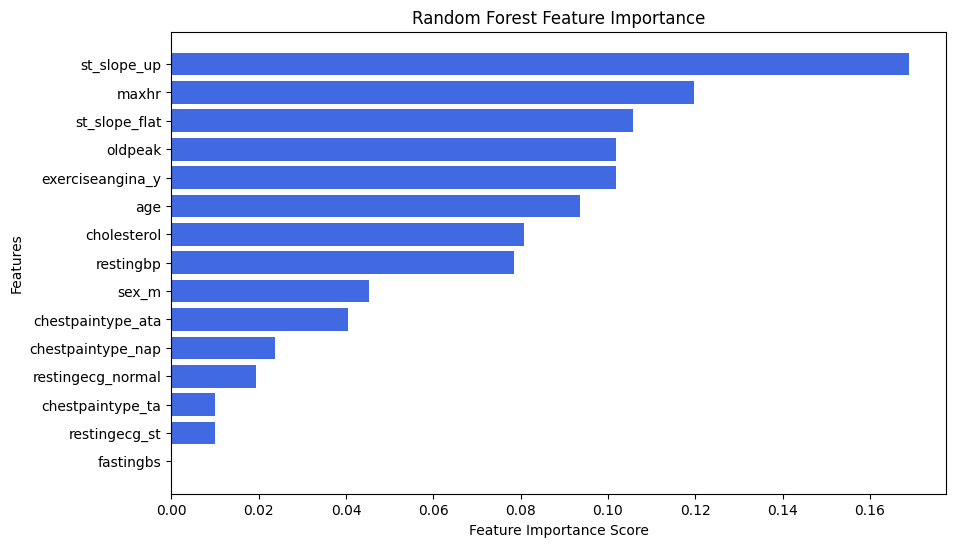

Selected Features: ['st_slope_up', 'maxhr', 'st_slope_flat', 'oldpeak', 'exerciseangina_y', 'age', 'cholesterol', 'restingbp', 'sex_m', 'chestpaintype_ata', 'chestpaintype_nap', 'restingecg_normal', 'chestpaintype_ta', 'restingecg_st', 'fastingbs']


In [60]:
# Separate features and target variable
X = df_cleaned.drop(columns=["heartdisease"])
y = df_cleaned["heartdisease"]

# Train a RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance scores
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a dataframe for visualization
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Select top features (either by count or threshold)
top_n = 15# Select top 10 features
selected_features = feature_importance_df.iloc[:top_n]["Feature"].tolist()

# Print selected features
print("Selected Features:", selected_features)


In [61]:
# Save Selected Features
joblib.dump(selected_features, os.path.join(models_dir, "selected_features.pkl"))

['C:\\Users\\User\\heart-disease-prediction\\notebooks\\models\\selected_features.pkl']

In [62]:
# Keep only selected features
X_selected = X[selected_features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

import numpy as np
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Print shape of the new dataset
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (560, 15)
X_test shape: (141, 15)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Accuracy: 0.900709219858156

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90        68
           1       0.89      0.92      0.91        73

    accuracy                           0.90       141
   macro avg       0.90      0.90      0.90       141
weighted avg       0.90      0.90      0.90       141



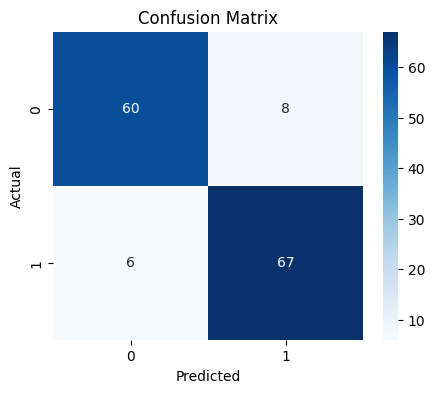

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Whether to bootstrap samples
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get best estimator
best_rf = grid_search_rf.best_estimator_
print("Best Parameters:", grid_search_rf.best_params_)

# Make predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Display Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [64]:
print(type(best_rf))


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [65]:
# Save the Best Model
joblib.dump(best_rf, os.path.join(models_dir, "best_rf_model.pkl"))

['C:\\Users\\User\\heart-disease-prediction\\notebooks\\models\\best_rf_model.pkl']

In [66]:
print("Selected Features in Model:", selected_features)

Selected Features in Model: ['st_slope_up', 'maxhr', 'st_slope_flat', 'oldpeak', 'exerciseangina_y', 'age', 'cholesterol', 'restingbp', 'sex_m', 'chestpaintype_ata', 'chestpaintype_nap', 'restingecg_normal', 'chestpaintype_ta', 'restingecg_st', 'fastingbs']


In [73]:
print("Expected Features from Training:", selected_features)



Expected Features from Training: ['st_slope_up', 'maxhr', 'st_slope_flat', 'oldpeak', 'exerciseangina_y', 'age', 'cholesterol', 'restingbp', 'sex_m', 'chestpaintype_ata', 'chestpaintype_nap', 'restingecg_normal', 'chestpaintype_ta', 'restingecg_st', 'fastingbs']


In [74]:
import pandas as pd
import numpy as np
import joblib

# Load the trained model
model_path = "best_rf_model.pkl"
model = joblib.load(model_path)

# Create a sample test input with ALL expected features
sample_input = pd.DataFrame([[1, 150, 0, 2.3, 1, 63, 233, 145, 1, 0, 0, 1, 0, 1, 0]], 
                            columns=['st_slope_up', 'maxhr', 'st_slope_flat', 'oldpeak', 
                                     'exerciseangina_y', 'age', 'cholesterol', 'restingbp', 
                                     'sex_m', 'chestpaintype_ata', 'chestpaintype_nap', 
                                     'chestpaintype_ta', 'restingecg_normal', 
                                     'restingecg_st', 'fastingbs'])

# Convert to NumPy array, ensure correct shape
sample_input_array = np.array(sample_input, dtype=np.float64).reshape(1, -1)

# Make a prediction
prediction = model.predict(sample_input_array)
prediction_proba = model.predict_proba(sample_input_array)

print(f"Prediction: {prediction[0]}")  # 0 = No Heart Disease, 1 = Heart Disease
print(f"Probability: {prediction_proba[0]}")


Prediction: 1
Probability: [0.38678199 0.61321801]


In [77]:
print("Columns in Training Data:")
print(df_cleaned.columns.tolist())


Columns in Training Data:
['age', 'restingbp', 'cholesterol', 'fastingbs', 'maxhr', 'oldpeak', 'heartdisease', 'sex_m', 'chestpaintype_ata', 'chestpaintype_nap', 'chestpaintype_ta', 'restingecg_normal', 'restingecg_st', 'exerciseangina_y', 'st_slope_flat', 'st_slope_up']
